In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

In [2]:
audio_file = "harvard.wav"

In [3]:
signal, sr = librosa.load(audio_file, sr=None)

In [8]:
print('Original Sampling Frequency:', sr)
print('Original Bit Resolution:', signal.dtype)
print("Signal length: ", len(signal))

Original Sampling Frequency: 44100
Original Bit Resolution: float32
Signal length:  809508


In [9]:
cut_signal = signal[int(sr*5.2):sr*7]

In [26]:
display(Audio(cut_signal, rate=sr))

In [13]:
def energy_based_vad(signal, sr):
    # Compute the short-term energy of the signal
    energy = librosa.feature.rms(y=signal, frame_length=2048, hop_length=512)[0]

    # Set a threshold to classify frames as voiced, unvoiced, or silent
    threshold = np.mean(energy) * 1.5  # Adjust multiplier as needed

    # Classify frames based on energy
    voiced_segments = []
    unvoiced_segments = []
    silent_segments = []

    current_segment_start = 0
    for i, e in enumerate(energy):
        if e > threshold:
            # Voiced segment
            if not voiced_segments:
                current_segment_start = i
            elif unvoiced_segments:
                unvoiced_segments.pop()
            elif silent_segments:
                silent_segments.pop()
        else:
            # Unvoiced or silent segment
            if voiced_segments:
                voiced_segments.append((current_segment_start, i))
            elif not unvoiced_segments:
                current_segment_start = i
            elif voiced_segments:
                voiced_segments.pop()

    # Add the last segment if it's voiced
    if voiced_segments:
        voiced_segments.append((current_segment_start, len(energy)))
    elif unvoiced_segments:
        unvoiced_segments.append((current_segment_start, len(energy)))
    elif silent_segments:
        silent_segments.append((current_segment_start, len(energy)))

    return voiced_segments, unvoiced_segments, silent_segments

In [27]:
def display_speech_regions(signal, sr):
    # Compute voiced, unvoiced, and silent regions
    voiced_segments, unvoiced_segments, silent_segments = energy_based_vad(signal, sr)  # You need to define energy_based_vad function

    # Define colors for plotting
    colors = ['blue', 'red', 'green']

    # Plot the speech signal with voice, unvoiced, and silent regions
    plt.figure(figsize=(12, 8))

    # Plot original waveform
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(signal, sr=sr, alpha=0.5, color='gray')
    plt.title('Original Speech Signal')

    # Plot silent regions
    plt.subplot(2, 2, 2)
    plot_with_regions(signal, sr, silent_segments, colors[0], 'Silent Regions')

    # Plot unvoiced regions
    plt.subplot(2, 2, 3)
    plot_with_regions(signal, sr, unvoiced_segments, colors[1], 'Unvoiced Regions')

    # Plot voiced regions
    plt.subplot(2, 2, 4)
    plot_with_regions(signal, sr, voiced_segments, colors[2], 'Voiced Regions')

    plt.tight_layout()
    plt.show()

def plot_with_regions(signal, sr, segments, color, title):
    librosa.display.waveshow(signal, sr=sr, alpha=0.5, color='gray')
    for start, end in segments:
        plt.axvspan(librosa.frames_to_time(start), librosa.frames_to_time(end), color=color, alpha=0.3, lw=0)
    plt.title(title)


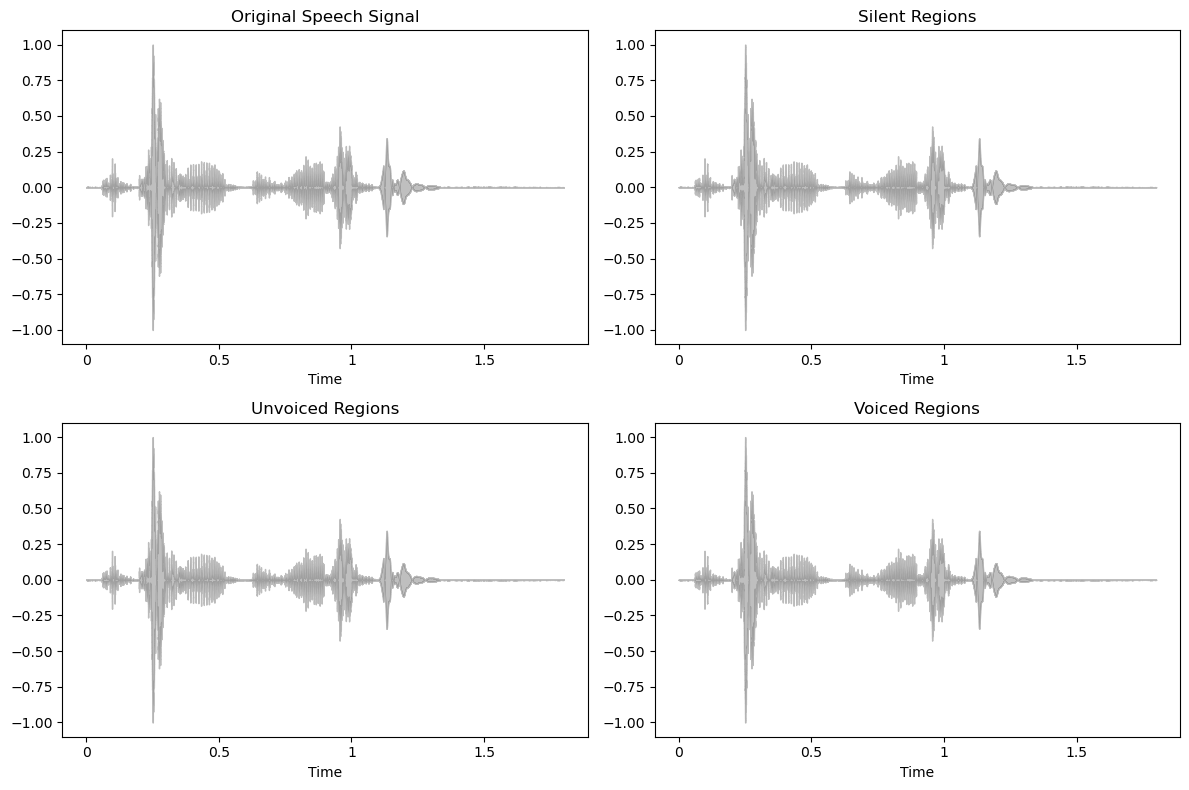

In [19]:
display_speech_regions(cut_signal, sr)